Name: Harsh Pandey

College: IIT BHU Varanasi

GitHub: [harsh1245-bit](https://https://github.com/harsh1245-bit)

Using Google Colab, hence importing Drive to access files

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Import Necessary Libraries to accessing and using the data for modelling.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import copy
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tarfile
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler



# **Data**

Extracting the data into a directory named, lens_dir

In [ ]:
'''
fname = '/content/drive/MyDrive/GSoC/lenses.tgz'
extract_path = '/content/drive/MyDrive/GSoC'

with tarfile.open(fname, "r:gz") as tar:
    tar.extractall(extract_path)
    tar.close()
'''

'\nfname = \'/content/drive/MyDrive/GSoC/lenses.tgz\'\nextract_path = \'/content/drive/MyDrive/GSoC\'\n\nwith tarfile.open(fname, "r:gz") as tar:\n    tar.extractall(extract_path)\n    tar.close()\n'

Allocating Lens Directory's path

In [ ]:
lens_dir = '/content/drive/MyDrive/lenses'

Dividing them into sub directories

In [ ]:
sub_dir = os.path.join(lens_dir, 'sub')
no_sub_dir = os.path.join(lens_dir, 'no_sub')

Using PyTorch's `ImageFolder` to store data as images

In [ ]:
dataset = ImageFolder(lens_dir)

Checking the distribution of images in each sub category

In [ ]:
np.unique(dataset.targets, return_counts=True)

(array([0, 1]), array([5000, 5000]))

Mapping the label indexes

In [ ]:
print(dataset.class_to_idx)

{'no_sub': 0, 'sub': 1}


Creating an elaborate dataset that lets us apply transforms to the data and returns us individual items 

In [ ]:
class LensDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):            
        data = self.transform(dataset[idx][0])
        label = dataset[idx][1]        
        
        return data, label

    def __len__(self):
        return len(self.dataset)

Let us prepare the data in a bit more neat way for AAE

Transforming the data for Data Augmentation 

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      #transforms.RandomRotation(5),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.Resize((150, 150)),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      transforms.Grayscale(num_output_channels=1)
                                      ])

eval_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((150, 150)),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     transforms.Grayscale(num_output_channels=1)
                                     ])

# Preparing the Data for Training/Testing

We are gonna split the data into given size in the task i.e. 90 for train and 10 for test

In [ ]:
train_dataset = LensDataset(dataset, train_transform)
test_dataset = LensDataset(dataset, eval_transform)

In [ ]:
np.random.seed(42) 

train_size = 0.9

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[:split], indices[split:]

train_data = Subset(train_dataset, indices=train_idx)
test_data = Subset(test_dataset, indices=test_idx)

In [ ]:
print(len(train_data),len(test_data))


9000 1000


we have to detect one class as an anomaly, we are taking sub as an anamoly class. Currently the data set consists of both the classes, and in this step we are removing the `sub class` from the data.

In [ ]:
no_sub_idx = []

for i, (data, label) in enumerate(train_data):
    print(i)
    if label == 0:
        no_sub_idx.append(i)

no_sub_idx = np.array(train_data.indices)[no_sub_idx]
train_data_no_sub = Subset(train_dataset, no_sub_idx)

len(train_data_no_sub)

In [81]:
for data, label in train_data_no_sub:
    if label != 0:
        print('not okay!', label)

Creating DataLoaders, that we are going to use in training and testing. Batch size = 64

In [49]:
train_all_dataloader = DataLoader(train_data, shuffle=True, batch_size=1, num_workers=8)
train_no_sub_dataloader = DataLoader(train_data_no_sub, shuffle=True, batch_size=64, num_workers=8)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=1, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
for _, labels in test_dataloader:
    print(labels)
    break

tensor([1])


# **Adversial Auto Encoder Architecture**

> Adversarial Autoencoder (AAE) is a clever idea of blending the autoencoder architecture with the adversarial loss concept introduced by GAN. It uses a similar concept with Variational Autoencoder (VAE) except that it uses adversarial loss to regularize the latent code instead of the KL-divergence that VAE uses.






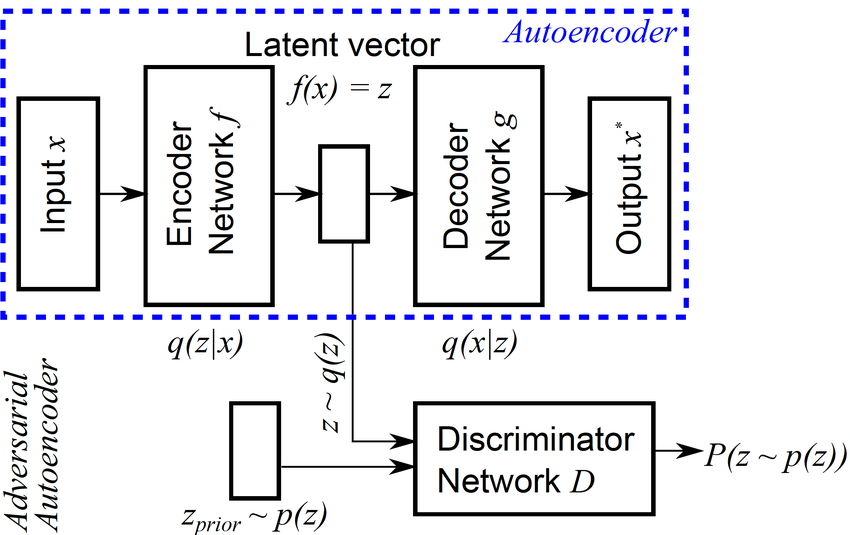

There are three options of the type of encoder that you can use:

1. Deterministic, this is the same encoder used in autoencoder, the encoder will try to compress the input into certain features represented as vector z.

2. Gaussian Posterior, this is the same encoder used in VAE, instead of encoding it into a single value for each feature, the encoder will store the gaussian distribution of each feature with 2 variables, mean and variance.

3. Universal Approximator Posterior, this also encodes the features as distribution. Except that, we do not assume the feature distribution to follow a gaussian distribution. In this case, the encoder will be a function f(x, n), where x is the input and n is a random noise that follows any arbitrary distribution.

Therefore, AAE architecture consists of these components:

1. Encoder, the encoder will take the input and transform it into a lower dimension (latent code z)

2. Decoder, the decoder will take the latent code z and transform it into the generated image.

3. Discriminator, the discriminator takes random vector z sampled from the chosen distribution (real) and also the encoded latent code z (fake) from the autoencoder as the input. It will check whether the input is real or not.

In [51]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 7, stride=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(5184, 1000)

    def forward(self, x):
        convolution1 = F.relu(self.conv1(x))
        convolution2 = F.relu(self.conv2(convolution1))
        convolution3 = F.relu(self.conv3(convolution2))
        Flattened = self.flat(convolution3)
        z = self.linear(Flattened)

        return z

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(1000, 5184)
        self.conv4 = nn.ConvTranspose2d(64, 32, 7)
        self.conv5 = nn.ConvTranspose2d(32, 16, 7, stride=3, padding=1, output_padding=2)
        self.conv6 = nn.ConvTranspose2d(16, 1, 6, stride=3, padding=1, output_padding=2)

    def forward(self, x):
        hidden = self.linear(x)
        Reshaped = hidden.reshape(-1,64,9,9)
        convolution4 = F.relu(self.conv4(Reshaped))
        convolution5 = F.relu(self.conv5(convolution4))
        predicted = torch.tanh(self.conv6(convolution5))

        return predicted

class Discriminator(nn.Module):
    def __init__(self, dim_z=1000 , dim_h=256):
        super(Discriminator,self).__init__()
        
        self.dim_z = dim_z
        self.dim_h = dim_h
        self.network = []
        self.network.extend([
            nn.Linear(self.dim_z, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h,1),
            nn.Sigmoid(),
        ])
        self.network = nn.Sequential(*self.network)

    def forward(self, z):
        disc = self.network(z)

        return disc

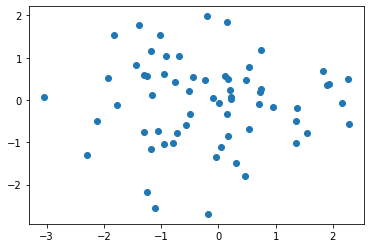

In [52]:
z_distribution = torch.randn(64, 1000)
plt.scatter(z_distribution[:,0], z_distribution[:,1])
plt.show()

Here $64$ represents the batch size, which is a hyperparameter and $1000$ is the size of our latent vector. This is made more easily understandable while looking at the training loops.

# Loading the model

Device that we are going to use.

In [53]:
global device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Defining functions to load the model and also the pre-trained model.

For loading the model

In [55]:
def load_model():
    """
    Loads the model
    """
    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator

For loading pre-trained model:

In [56]:
def load_model_pretrained(encoder_model, decoder_model, discriminator_model):
    """
    Loads the model by being given the path to the architecture + weights of each network
    """
    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder = torch.load(encoder_model, map_location=device)
    decoder = torch.load(decoder_model, map_location=device)
    discriminator = torch.load(discriminator_model, map_location=device)

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator

Defining a way to load the history and weights of the model:

In [57]:
def load_weights_and_history(save_path):
    """
    Loads the model weights and history
    """
    s = torch.load(save_path, map_location=device)

    history = s['history']

    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder.load_state_dict(s['encoder_weights'])
    decoder.load_state_dict(s['decoder_weights'])
    discriminator.load_state_dict(s['discriminator_weights'])

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator, history

## Creating a method for training loop

Defining a function to tarin the model

In [58]:
def train_model(encoder, decoder, discriminator, train_dataloader, epochs, save_path, viz=False):
    """
    Train the AAE.

    Inputs:
    -------
    encoder: the encoder model.
    
    decoder: the decoder model.
    
    discriminator: the discriminator model.

    train_dataloader: a `DataLoader` based on a `LensDataset`.

    epochs: number of epochs to train on (int).

    save_path: path to save the model's weights and history (str).

    viz: if `True`, after each epoch a original image - reconstructed image pair will be plotted
    """
    # --- HYPERPARAMETERS --- (these could be function arguments, but for simplicity sake we'll make them fixed)
    # reconstruction phase:
    reconstruction_criterion = nn.MSELoss()
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4)

    # regularization phase:
    def discriminator_criterion(input, target, epsilon):
        return -torch.mean(torch.log(target + epsilon) + torch.log(1 - input + epsilon))

    def generator_criterion(input, epsilon):
        return -torch.mean(torch.log(input + epsilon))

    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)
    generator_optimizer = optim.Adam(encoder.parameters(), lr=1e-5)

    # set learning rate schedulers (a more thorough analysis of this would be really useful!)
    # as of now i'm using default parameters to all optimizers
    encoder_scheduler = lr_scheduler.StepLR(encoder_optimizer, step_size=7, gamma=0.1)
    decoder_scheduler = lr_scheduler.StepLR(decoder_optimizer, step_size=7, gamma=0.1)
    discriminator_scheduler = lr_scheduler.StepLR(discriminator_optimizer, step_size=7, gamma=0.1)
    generator_scheduler = lr_scheduler.StepLR(generator_optimizer, step_size=7, gamma=0.1)

    # --- HISOTRY ---
    history = {'reconstruction_losses': [],
                'discriminator_losses': [],
                'generator_losses': []}

    # --- TRAINING LOOP ---
    epsilon = 1e-10 # prevents the loss from getting to zero

    reconstruction_losses = []
    discriminator_losses = []
    generator_losses = []

    for epoch in range(epochs):
        decoder.train()
        encoder.train()
        discriminator.train()

        running_reconstruction_loss = 0.0
        running_discriminator_loss = 0.0
        running_generator_loss = 0.0

        loop = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True)
        for data, label in loop:
            data = data.to(device)

            # zero the gradients
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            generator_optimizer.zero_grad()

            # RECONSTRUCTION PHASE
            # pass data through the autoencoder
            z_sample = encoder(data)
            x_sample = decoder(z_sample)

            # compute the loss
            reconstruction_loss = reconstruction_criterion(input=x_sample, target=data)
                
            # backpropagate and update weights
            reconstruction_loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()

            # REGULARIZATION PHASE - DISCRIMINATOR
            encoder.eval()
                
            # generate target latent space data according to a gaussian distribution
            z_real_gauss = Variable(torch.randn(data.size(0), 1000)) # 1000 fixed cuz its the encoder's input size
            z_real_gauss = z_real_gauss.to(device) # what we want
            z_fake_gauss = encoder(data) # what we currently have

            # determine discriminator classification of both samples
            d_real_gauss = discriminator(z_real_gauss) # real sampled gaussian 
            d_fake_gauss = discriminator(z_fake_gauss) # fake created gaussian

            # compute the loss
            discriminator_loss = discriminator_criterion(input=d_fake_gauss, target=d_real_gauss, epsilon=epsilon)
                
            # backpropagate and update weights
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # REGULARIZATION PHASE - GENERATOR
            encoder.train()

            z_fake_gauss = encoder(data)
            d_fake_gauss = discriminator(z_fake_gauss)
                
            # compute the loss
            generator_loss = generator_criterion(input=d_fake_gauss, epsilon=epsilon)

            # backpropagate and update weights
            generator_loss.backward()
            generator_optimizer.step()

            # METRICS
            running_reconstruction_loss += reconstruction_loss.item()# * data.size(0)
            running_discriminator_loss += discriminator_loss.item()# * data.size(0)
            running_generator_loss += generator_loss.item()# * data.size(0)

            loop.set_description(f'Epoch {epoch+1}/{epochs}')

        # save metrics
        epoch_reconstruction_loss = running_reconstruction_loss / len(train_dataloader.dataset)
        epoch_discriminator_loss = running_discriminator_loss / len(train_dataloader.dataset)
        epoch_generator_loss = running_generator_loss / len(train_dataloader.dataset)

        reconstruction_losses.append(epoch_reconstruction_loss)
        discriminator_losses.append(epoch_discriminator_loss)
        generator_losses.append(epoch_generator_loss)

        # visualize the reconstruction
        if viz:
            fig, axs = plt.subplots(1,2)
            axs[0].imshow(data[0,0].detach().cpu().numpy())
            axs[1].imshow(x_sample[0,0].detach().cpu().numpy())
            plt.show()

        print(f'\n[Epoch {epoch+1}/{epochs}]', 'reconstruction loss: {:.4f}; discriminator loss: {:.4f}; generator loss: {:.4f}'.format(epoch_reconstruction_loss, epoch_discriminator_loss, epoch_generator_loss))

        # learning rate scheduler
        encoder_scheduler.step()
        decoder_scheduler.step()
        discriminator_scheduler.step()
        generator_scheduler.step()

    history['reconstruction_losses'] = reconstruction_losses
    history['discriminator_losses'] = discriminator_losses
    history['generator_losses'] = generator_losses

    torch.save({'encoder_weights': encoder.state_dict(),
                'decoder_weights': decoder.state_dict(),
                'discriminator_weights': discriminator.state_dict(),
                'history': history}, save_path)
        
    return encoder, decoder, discriminator, history

## Defining a function for visualising the metrics of the model

In [59]:
def metrics(history):
    """
    Plot the three metrics that are tracked during training.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18,5), dpi=200)

    epochs = len(history['reconstruction_losses'])

    axs[0].plot(range(1, epochs+1), history['reconstruction_losses'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Reconstruction loss')
    axs[0].set_title('Reconstruction loss')

    axs[1].plot(range(1, epochs+1), history['discriminator_losses'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Discriminator loss')
    axs[1].set_title('Discriminator loss')

    axs[2].plot(range(1, epochs+1), history['generator_losses'])
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Generator loss')
    axs[2].set_title('Generator loss')      
        
    plt.show()

# Defining a function to evaluate the model

There is a bit change in this code from the normal code which is published on the paper, because it is difficult to find good score in this much less time. Hence I am using the train data for finding the threshold. 

In [60]:
def find_thresh(encoder, decoder, discriminator, train_dataloader, viz=False):
    encoder.eval()
    decoder.eval()

    anomaly_scores = {0:[], 1:[]}
    mse = nn.MSELoss()

    print('\nfinding anomaly_scores statistics...')
    loop = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True)
    for data, label in loop:
        data = data.to(device)

        encoded = encoder(data)
        decoded = decoder(encoded)

        for i in range (data.shape[0]):
            anomaly_score = mse(data[0], decoded[0])

            if label[i] == 0:
                anomaly_scores[0].append(anomaly_score.item())
            else:
                anomaly_scores[1].append(anomaly_score.item())

    anomaly_list = list(anomaly_scores.values())
    anomaly_list = [item for sublist in anomaly_list for item in sublist]
    thresh = np.mean(anomaly_list)

    if viz == True:
        plt.figure(figsize=(7,7), dpi=200)
        plt.hist(anomaly_scores[0], bins='auto', color='b', alpha=.5, label='0')
        plt.hist(anomaly_scores[1], bins='auto', color='r', alpha=.5, label='1')
        plt.axvline(thresh, linestyle='--', c='black', label='thresh')
        plt.legend()
        plt.show()

    return thresh

Now we'll define a function that enables us to compare the labels assigned to images by the model with the images real labels. This step is for checking the accuracy of the model:

In [61]:
def evaluate(encoder, decoder, discriminator, test_dataloader, thresh):
    """
    Use the AAE for inference over the `test_dataloader` data. A label is assigned 
    depending on whether the anomaly_score, defined as the error between the original
    image and its reconstruction, is above or below `thresh`.

    Inputs:
    -------
    test_dataloader: a `DataLoader` based on a `LensDataset`

    thresh: a number that defines the label of an input image according to the error
    between the original image and its reconstruction. If error > thresh, label = 1; 
    if error <= thresh, label = 0 (float)
    """
    encoder.eval()
    decoder.eval()

    mse = nn.MSELoss()
    true_labels = []
    predictions = []
        
    loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
    for data, label in loop:
        data = data.to(device)
        label = label.to(device)

        encoded = encoder(data)
        decoded = decoder(encoded)

        for i in range (data.shape[0]):
            anomaly_score = mse(data[0], decoded[0])

            pred = int(anomaly_score > thresh)

            true_labels.append(label[i].item())
            predictions.append(pred)

    # plot the ROC
    plt.figure(figsize=(7,7), dpi=200)
    fp, tp, _ = roc_curve(true_labels, predictions)
    auroc = auc(fp, tp)

    auroc = float('{:.2f}'.format(auroc))
    n = f'auroc = {auroc}'

    plt.plot(fp, tp, label=n)
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend()
    plt.show()

    # plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['({0:.2%})'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(7,7), dpi=200)
    sns.heatmap(cm, annot=labels, fmt="")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# **Training the AAE(scratch version)**

Loading the model for pre-training

In [62]:
encoder_scratch, decoder_scratch, discriminator_scratch = load_model()

We are going to check how the model is performing without the actual training of the model, hence trying to reconstruct a random image.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(0)


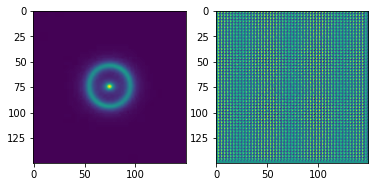

In [63]:
for data, label in train_no_sub_dataloader:
    data = data.to(device)

    z_sample = encoder_scratch(data)
    x_sample = decoder_scratch(z_sample)

    print(label[0])
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(data[0,0].detach().cpu().numpy())
    axs[1].imshow(x_sample[0,0].detach().cpu().numpy())
    plt.show()
    
    break

### Loading few of the sample images for the better visulaization of the images and the data for training

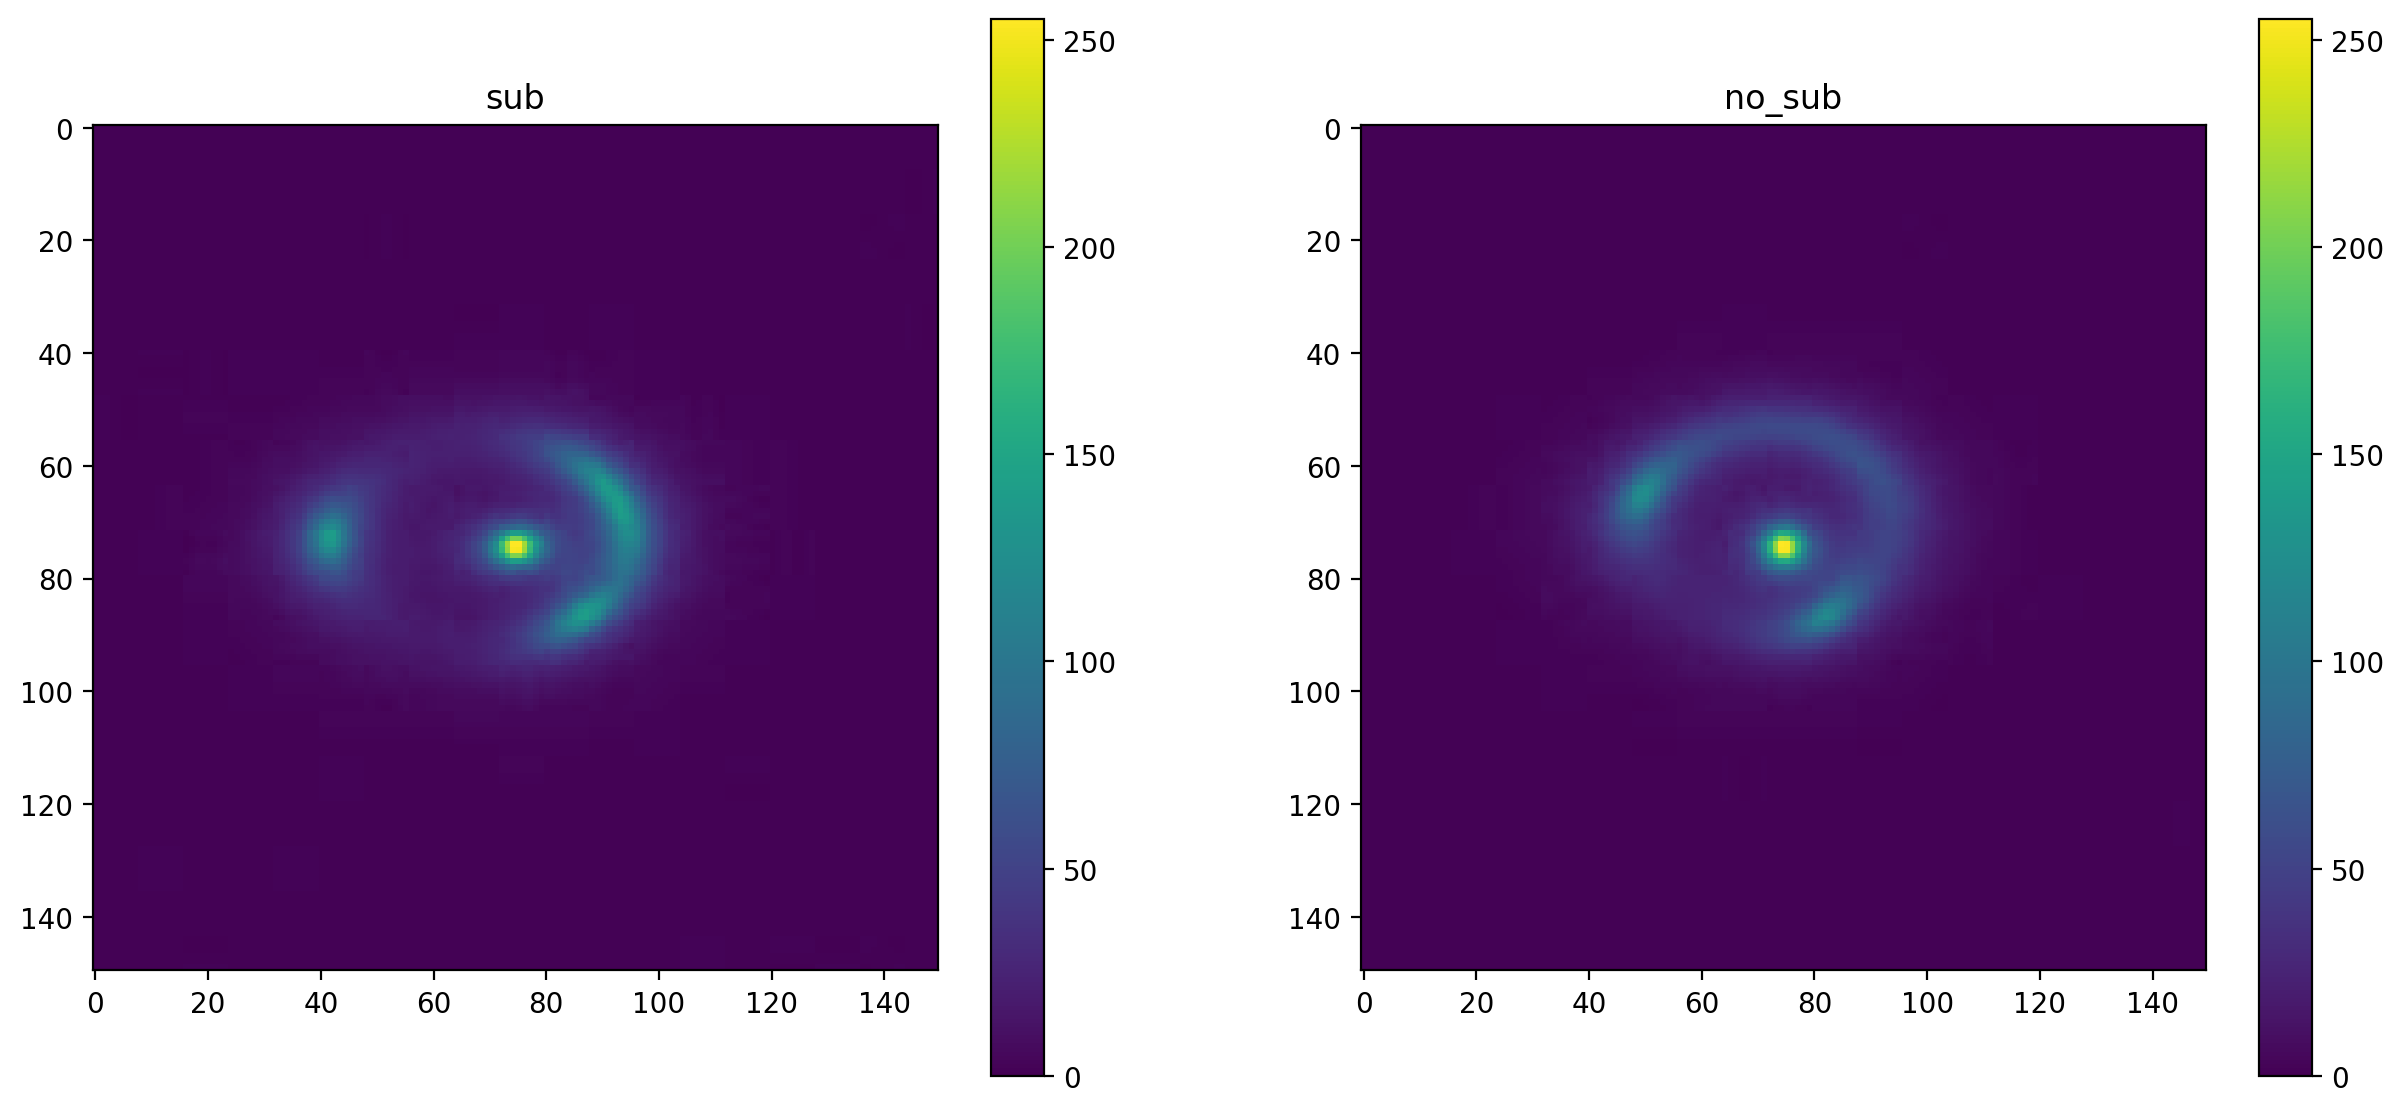

In [64]:
sub_img = PIL.Image.open(os.path.join(sub_dir,'image_471418625673875572041635641134845815.jpg'))
no_sub_img = PIL.Image.open(os.path.join(no_sub_dir,'image_701652002209044715780546468465808876.jpg'))

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
im1 = axs[0].imshow(sub_img)
axs[0].set_title('sub')
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(no_sub_img)
axs[1].set_title('no_sub')
plt.colorbar(im2, ax=axs[1])
plt.show()

#Training the model from the scratch not using the pre-trained weights

  0%|          | 0/71 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 1/32: 100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


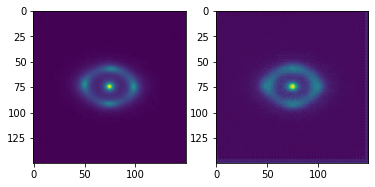

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 1/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1368


Epoch 2/32: 100%|██████████| 71/71 [01:47<00:00,  1.51s/it]


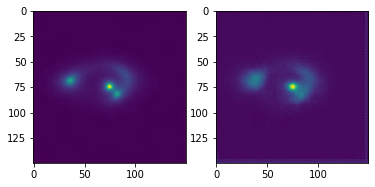

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 2/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1338


Epoch 3/32: 100%|██████████| 71/71 [01:46<00:00,  1.50s/it]


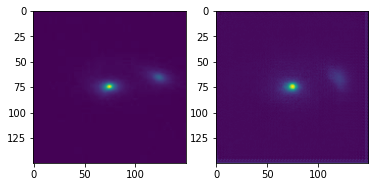

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 3/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1215


Epoch 4/32: 100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


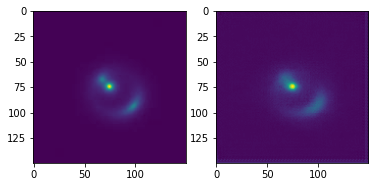

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 4/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1211


Epoch 5/32: 100%|██████████| 71/71 [01:46<00:00,  1.50s/it]


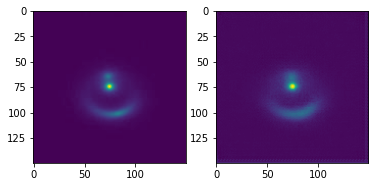

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 5/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1094


Epoch 6/32: 100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


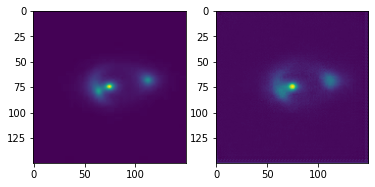

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 6/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1081


Epoch 7/32: 100%|██████████| 71/71 [01:46<00:00,  1.50s/it]


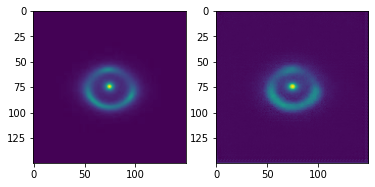

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 7/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1057


Epoch 8/32: 100%|██████████| 71/71 [01:46<00:00,  1.49s/it]


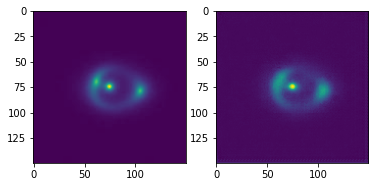

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 8/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.0992


Epoch 9/32: 100%|██████████| 71/71 [01:47<00:00,  1.51s/it]


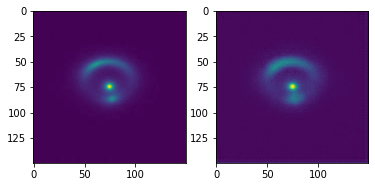

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 9/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1041


Epoch 10/32: 100%|██████████| 71/71 [01:46<00:00,  1.50s/it]


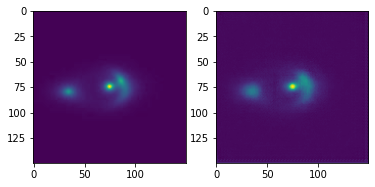

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 10/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1066


Epoch 11/32: 100%|██████████| 71/71 [01:47<00:00,  1.51s/it]


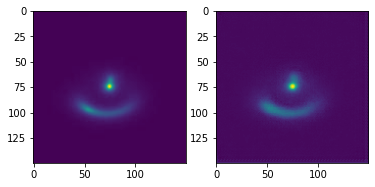

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 11/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1083


Epoch 12/32: 100%|██████████| 71/71 [01:47<00:00,  1.51s/it]


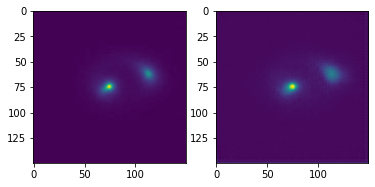

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 12/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1077


Epoch 13/32: 100%|██████████| 71/71 [01:47<00:00,  1.51s/it]


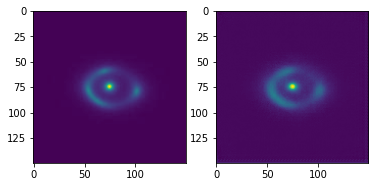

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 13/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1078


Epoch 14/32: 100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


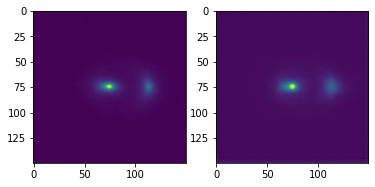

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 14/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1082


Epoch 15/32: 100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


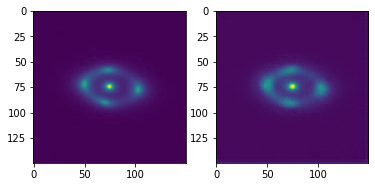

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 15/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1081


Epoch 16/32: 100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


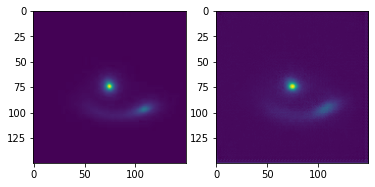

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 16/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1085


Epoch 17/32: 100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


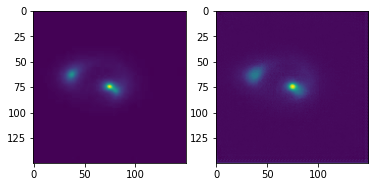

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 17/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1085


Epoch 18/32: 100%|██████████| 71/71 [01:50<00:00,  1.56s/it]


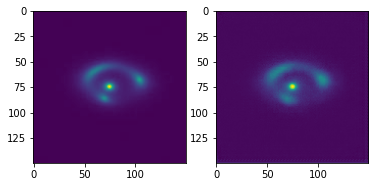

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 18/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1086


Epoch 19/32: 100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


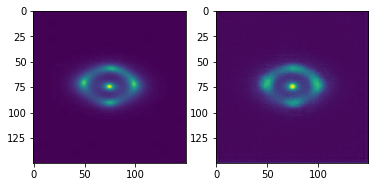

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 19/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1089


Epoch 20/32: 100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


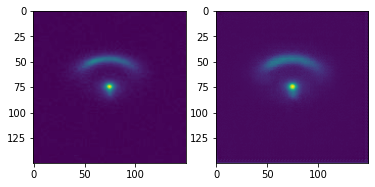

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 20/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1090


Epoch 21/32: 100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


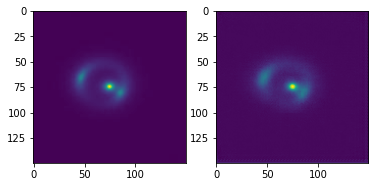

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 21/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1092


Epoch 22/32: 100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


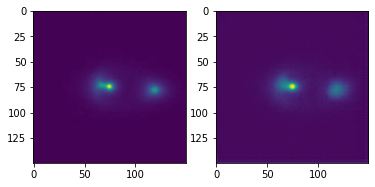

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 22/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1093


Epoch 23/32: 100%|██████████| 71/71 [01:49<00:00,  1.55s/it]


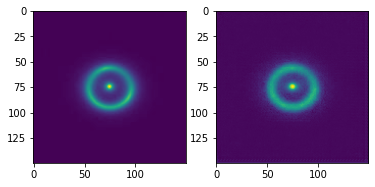

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 23/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1092


Epoch 24/32: 100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


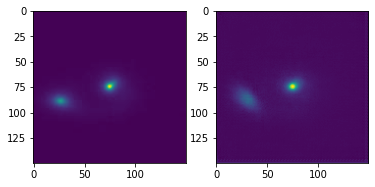

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 24/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1092


Epoch 25/32: 100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


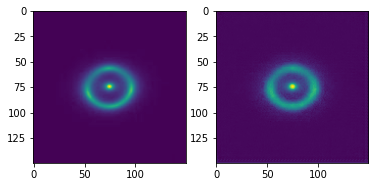

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 25/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1093


Epoch 26/32: 100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


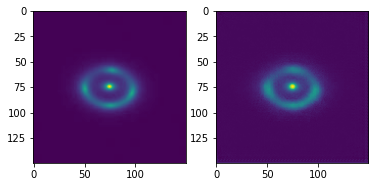

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 26/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1094


Epoch 27/32: 100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


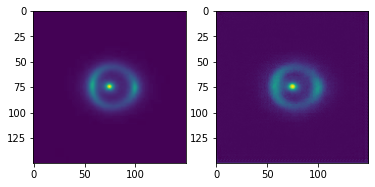

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 27/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1093


Epoch 28/32: 100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


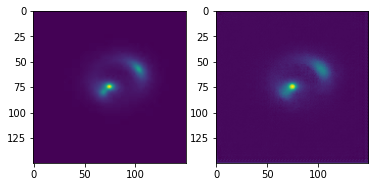

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 28/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1093


Epoch 29/32: 100%|██████████| 71/71 [01:48<00:00,  1.54s/it]


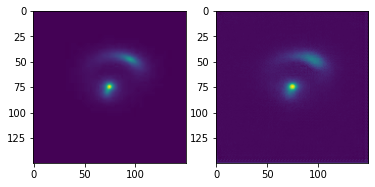

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 29/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1094


Epoch 30/32: 100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


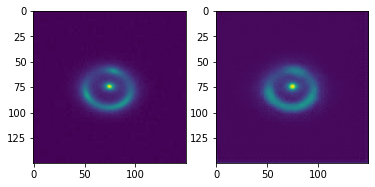

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 30/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1092


Epoch 31/32: 100%|██████████| 71/71 [01:50<00:00,  1.56s/it]


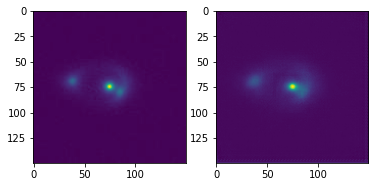

  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 31/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1094


Epoch 32/32: 100%|██████████| 71/71 [01:51<00:00,  1.57s/it]


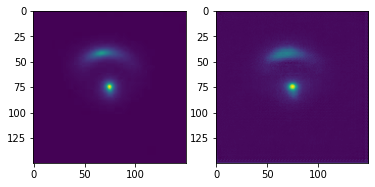


[Epoch 32/32] reconstruction loss: 0.0000; discriminator loss: 0.0000; generator loss: 0.1092


In [68]:
save_path_scratch = os.path.join('/content/drive/MyDrive/GSoC/', 'weights_history_scratch.pt')

encoder_scratch, decoder_scratch, discriminator_scratch, history_scratch = train_model(encoder_scratch, decoder_scratch, discriminator_scratch, train_no_sub_dataloader, 32, save_path_scratch, viz=True) 

### **Visualization of the training metrics**

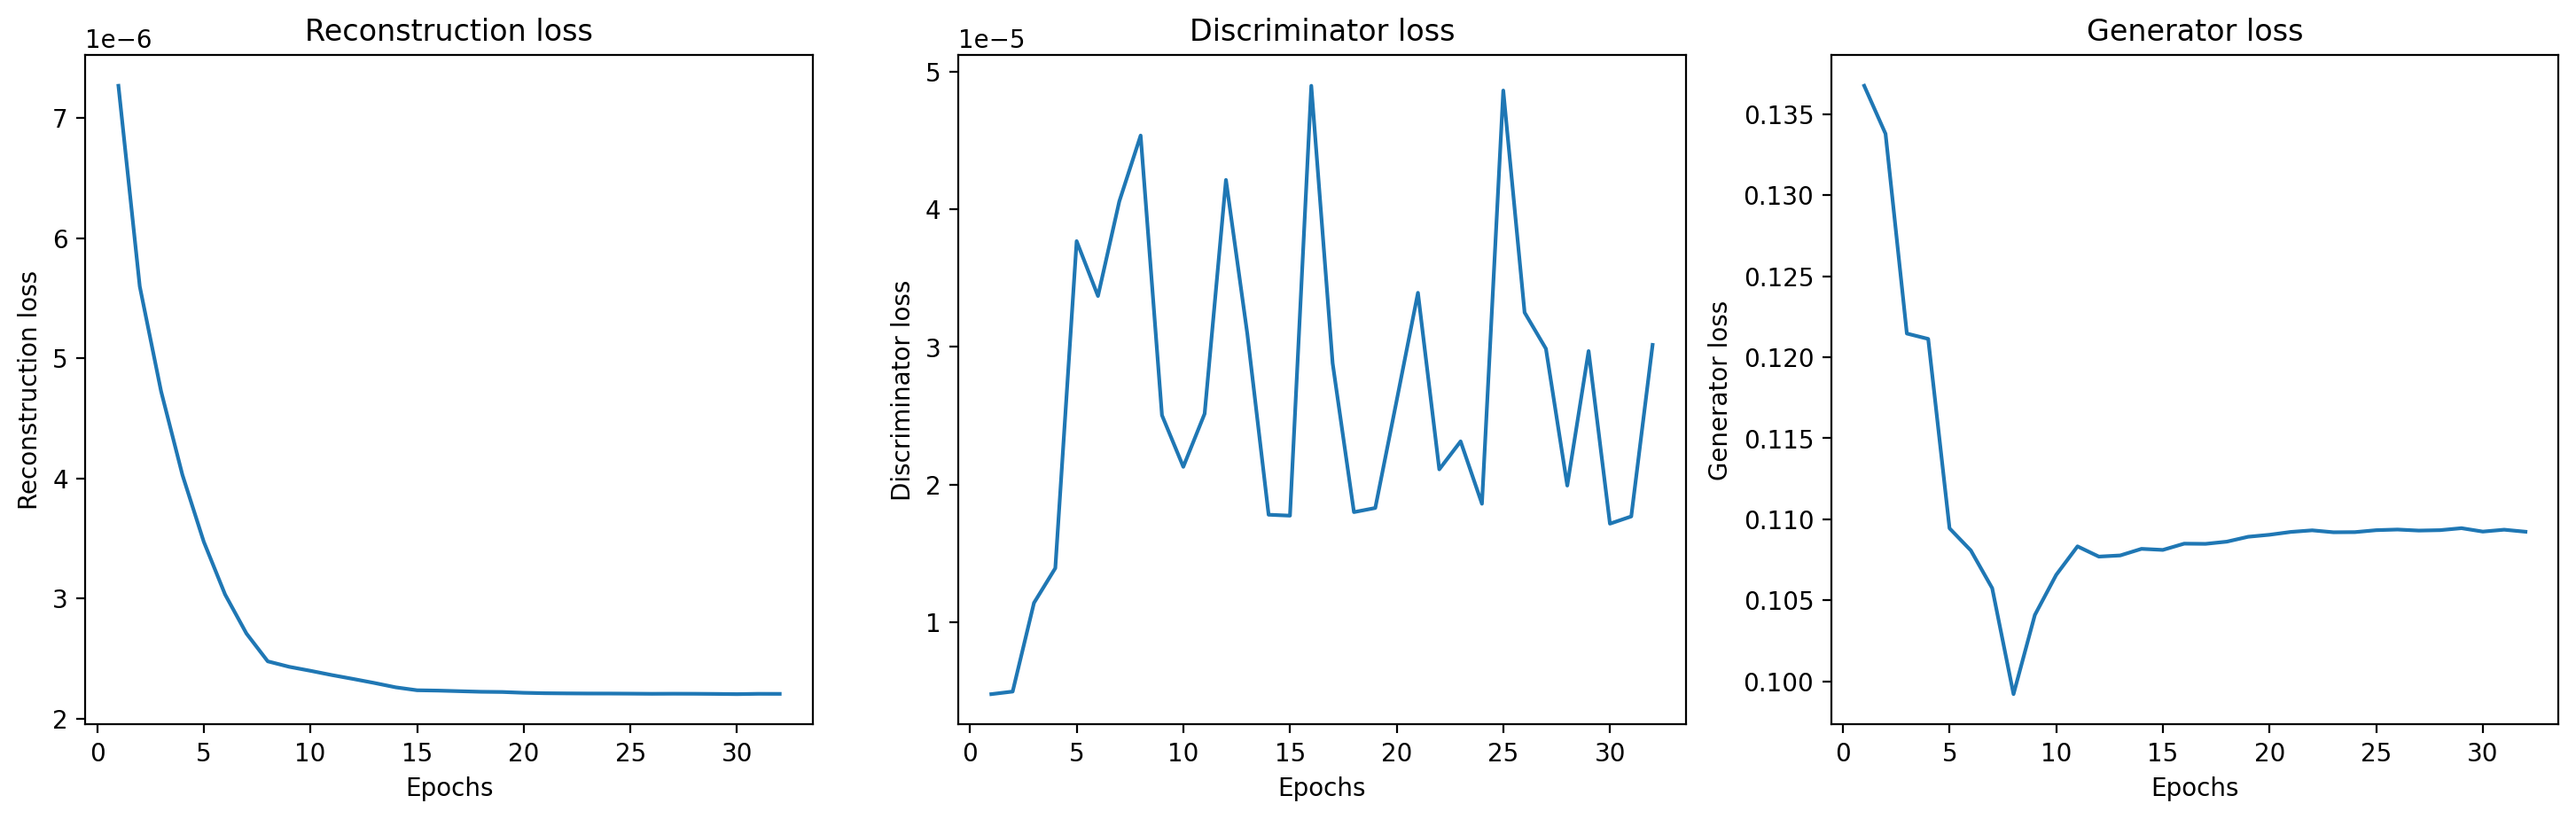

In [69]:

metrics(history_scratch)

### **Evaluation of the model on the testing set**

  0%|          | 0/9000 [00:00<?, ?it/s]


finding anomaly_scores statistics...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 9000/9000 [02:15<00:00, 66.27it/s]


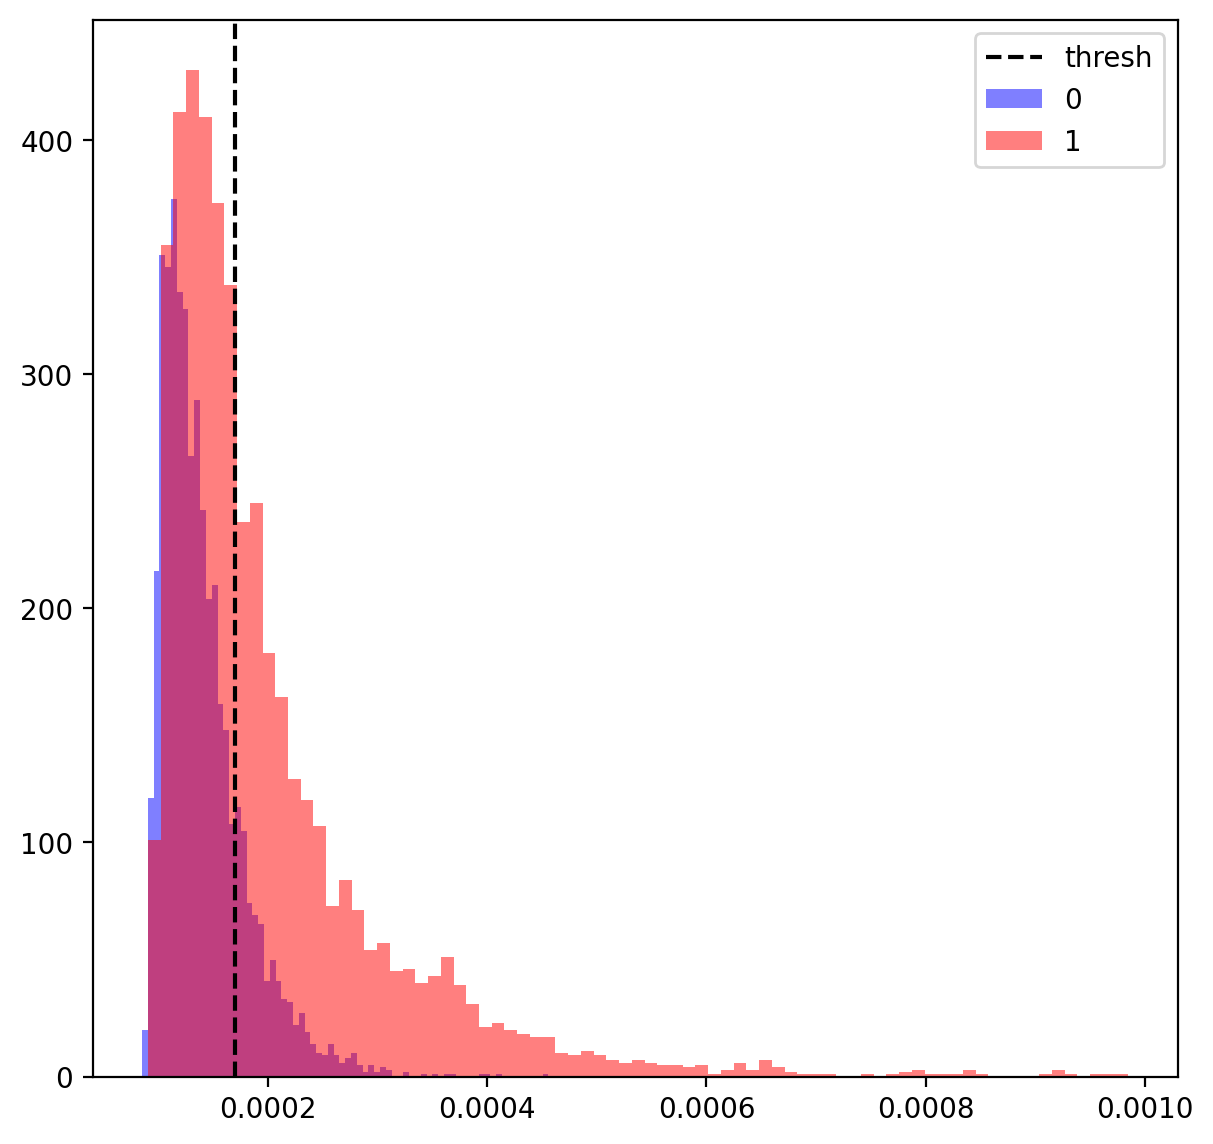

0.0001701394934878206

In [70]:
thresh_scratch = find_thresh(encoder_scratch, decoder_scratch, discriminator_scratch, train_all_dataloader, viz=True)
thresh_scratch

100%|██████████| 1000/1000 [01:33<00:00, 10.67it/s]


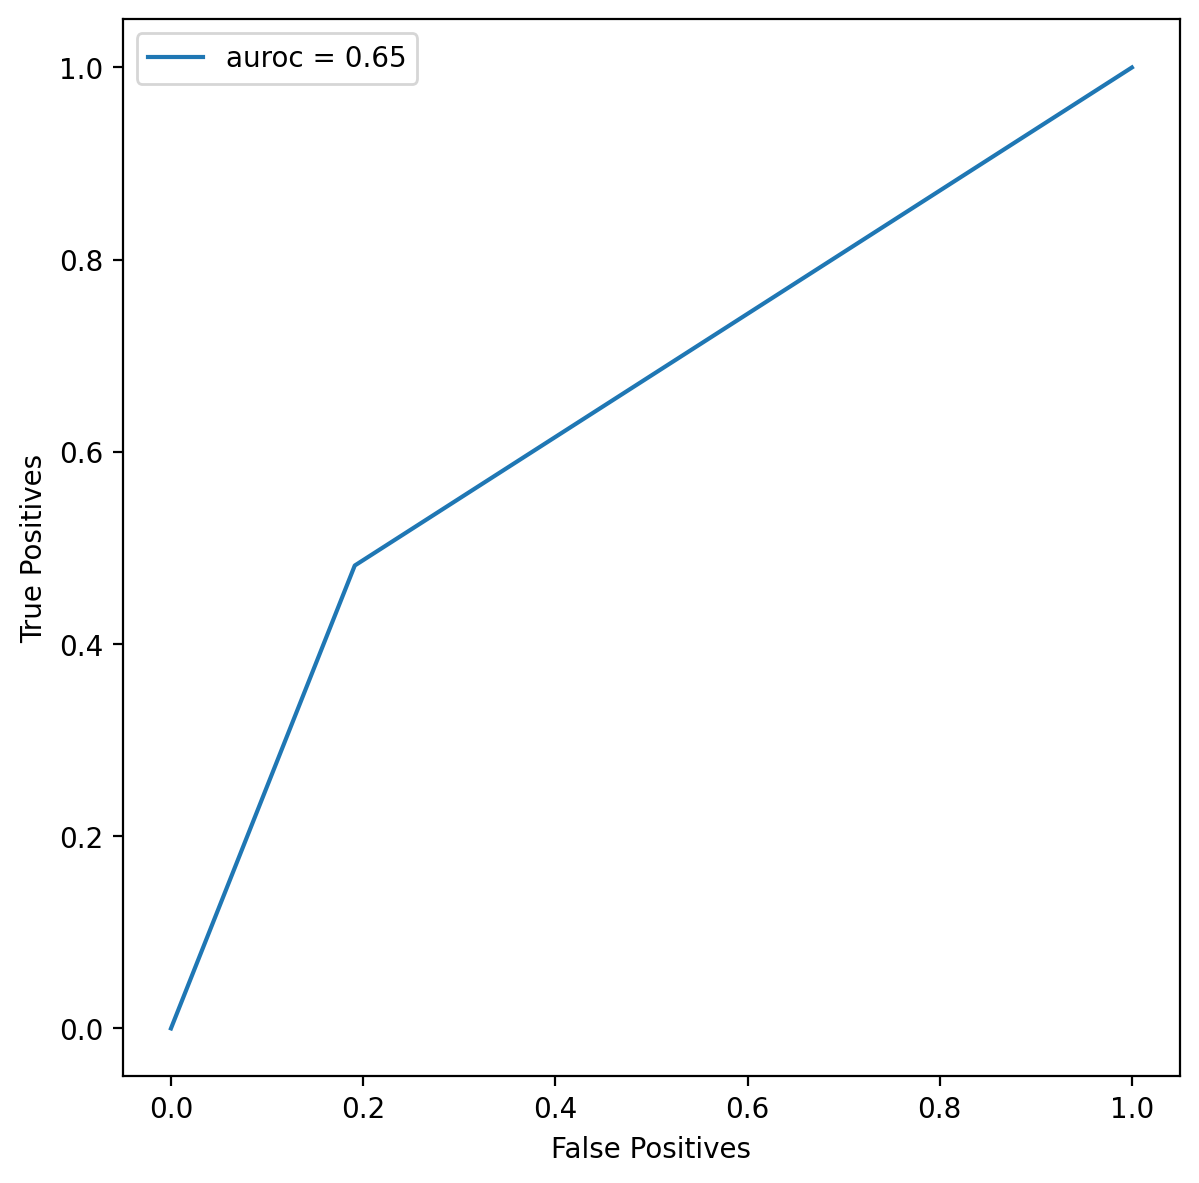

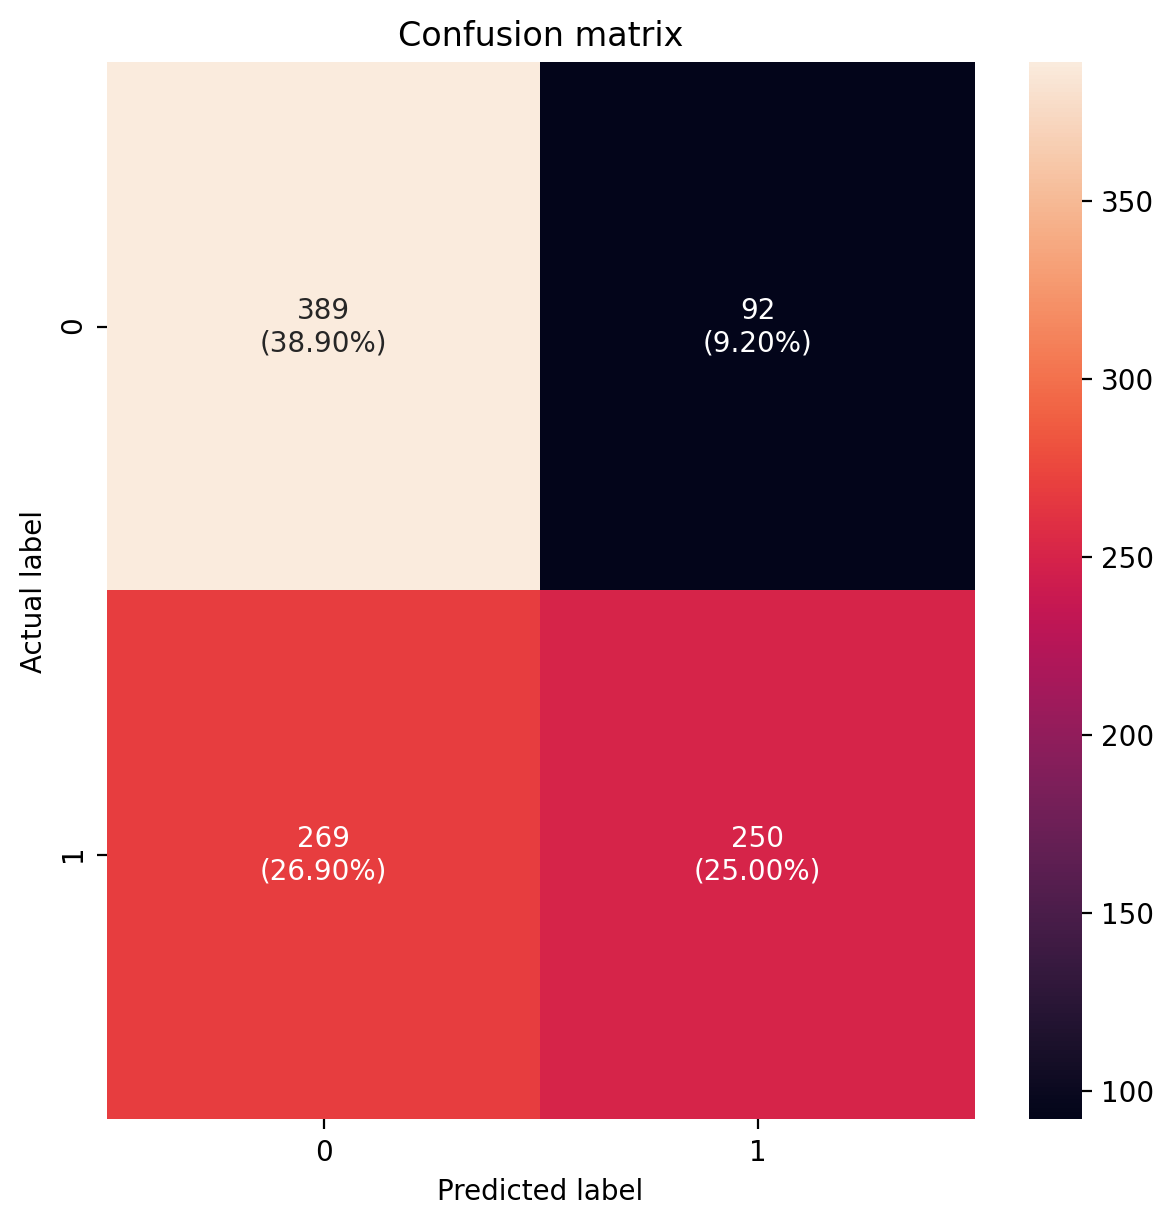

In [71]:
dec_list = evaluate(encoder_scratch, decoder_scratch, discriminator_scratch, test_dataloader, thresh_scratch)

# Pre-Trained AAE model for freature extraction 

Loading models

In [72]:
encoder_weights = '/content/drive/MyDrive/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Encoder.pth'
decoder_weights = '/content/drive/MyDrive/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Decoder.pth'
discriminator_weights = '/content/drive/MyDrive/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'

encoder_fe, decoder_fe, discriminator_fe = load_model_pretrained(encoder_weights, decoder_weights, discriminator_weights)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.flatten.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.

There is no need to train this model, so we should use this as it is:

## Evaluation of the model

  0%|          | 0/9000 [00:00<?, ?it/s]


finding anomaly_scores statistics...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 9000/9000 [02:14<00:00, 66.82it/s]


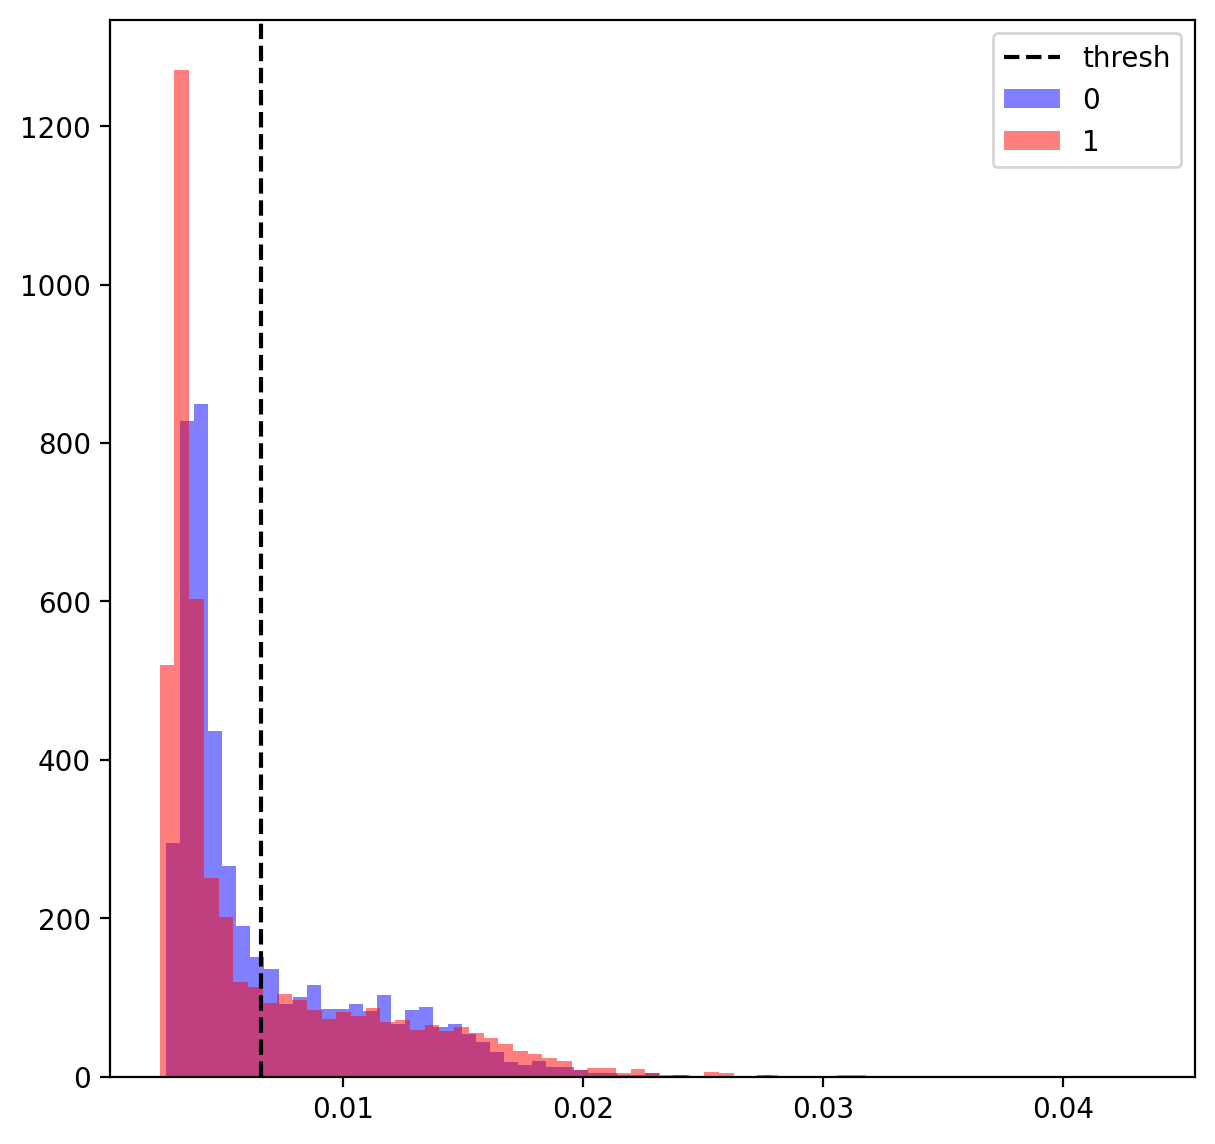

0.006549127896109389

In [73]:
thresh_fe = find_thresh(encoder_fe, decoder_fe, discriminator_fe, train_all_dataloader, viz=True)
thresh_fe

100%|██████████| 1000/1000 [00:14<00:00, 70.77it/s]


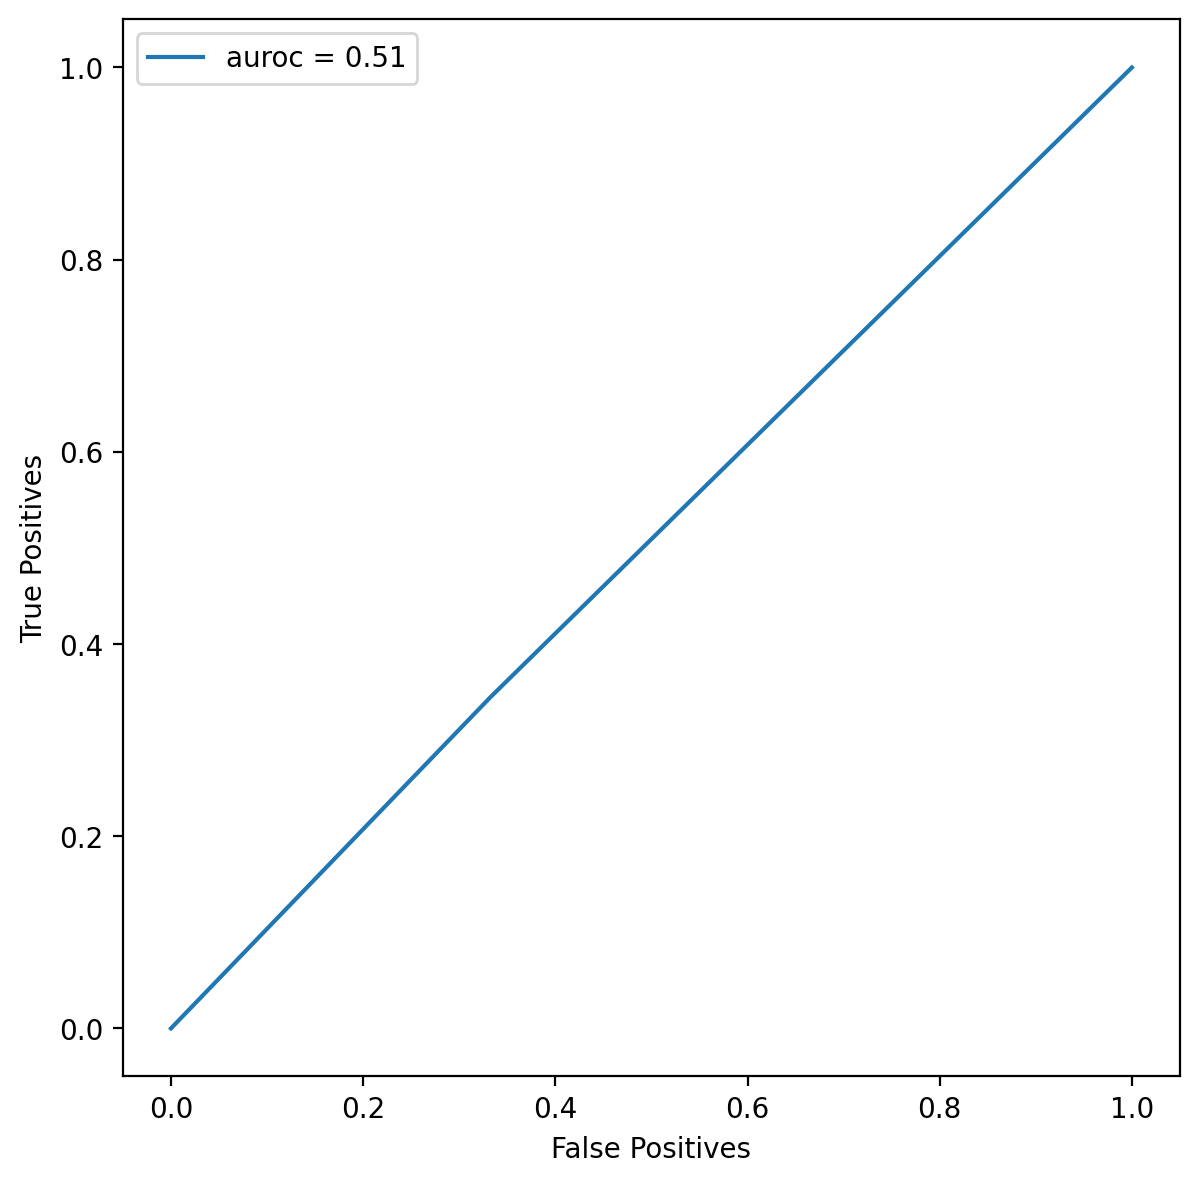

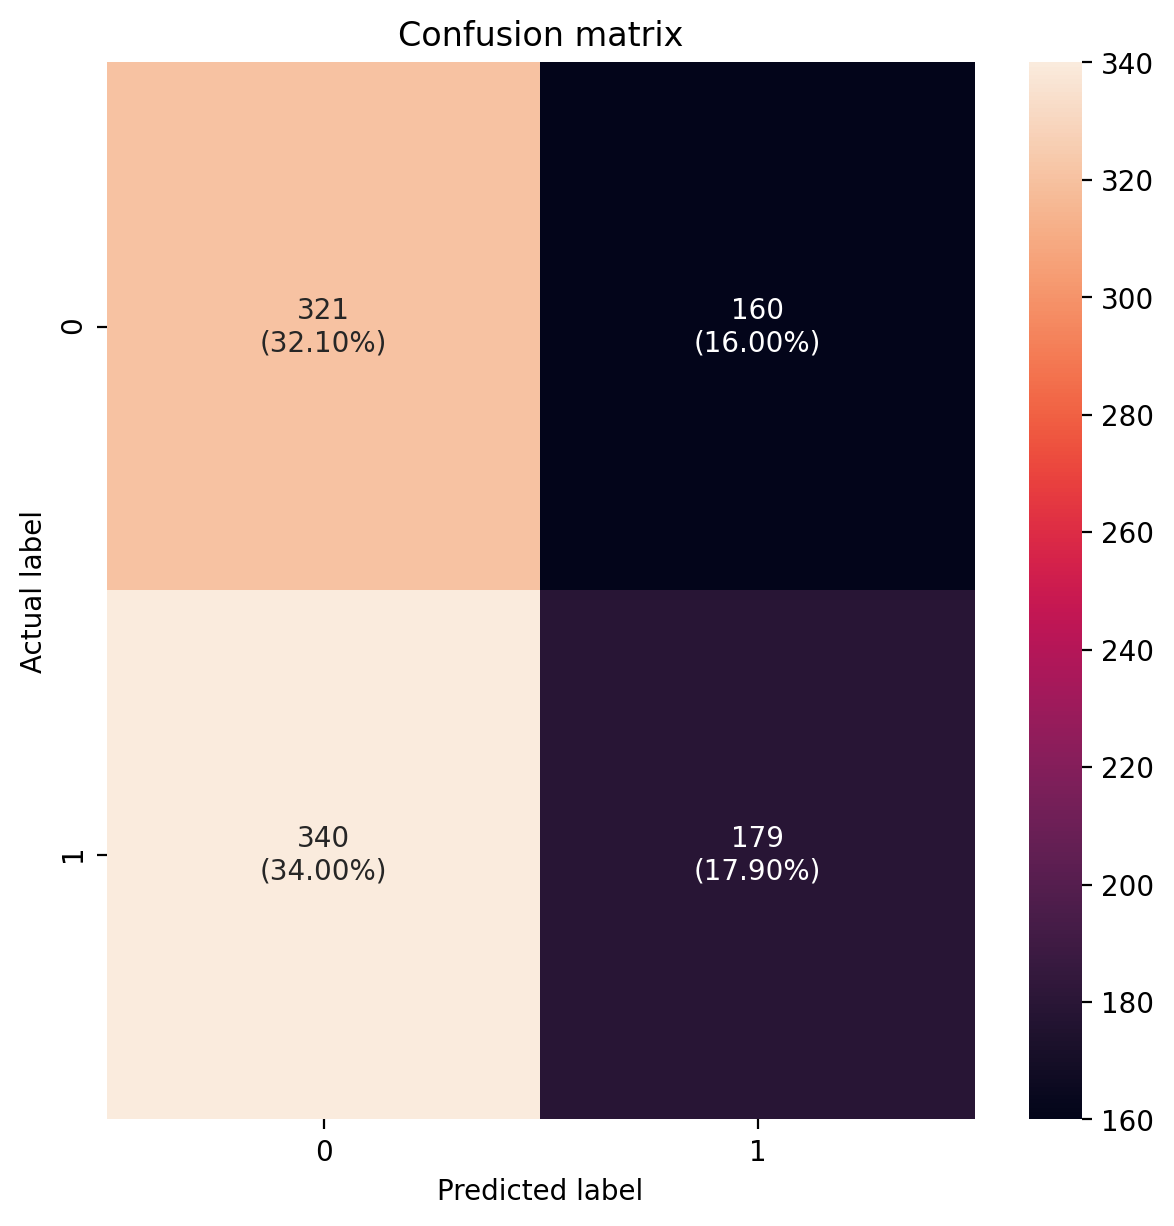

In [74]:
evaluate(encoder_fe, decoder_fe, discriminator_fe, test_dataloader, thresh_fe)

100%|██████████| 1000/1000 [00:13<00:00, 73.44it/s]


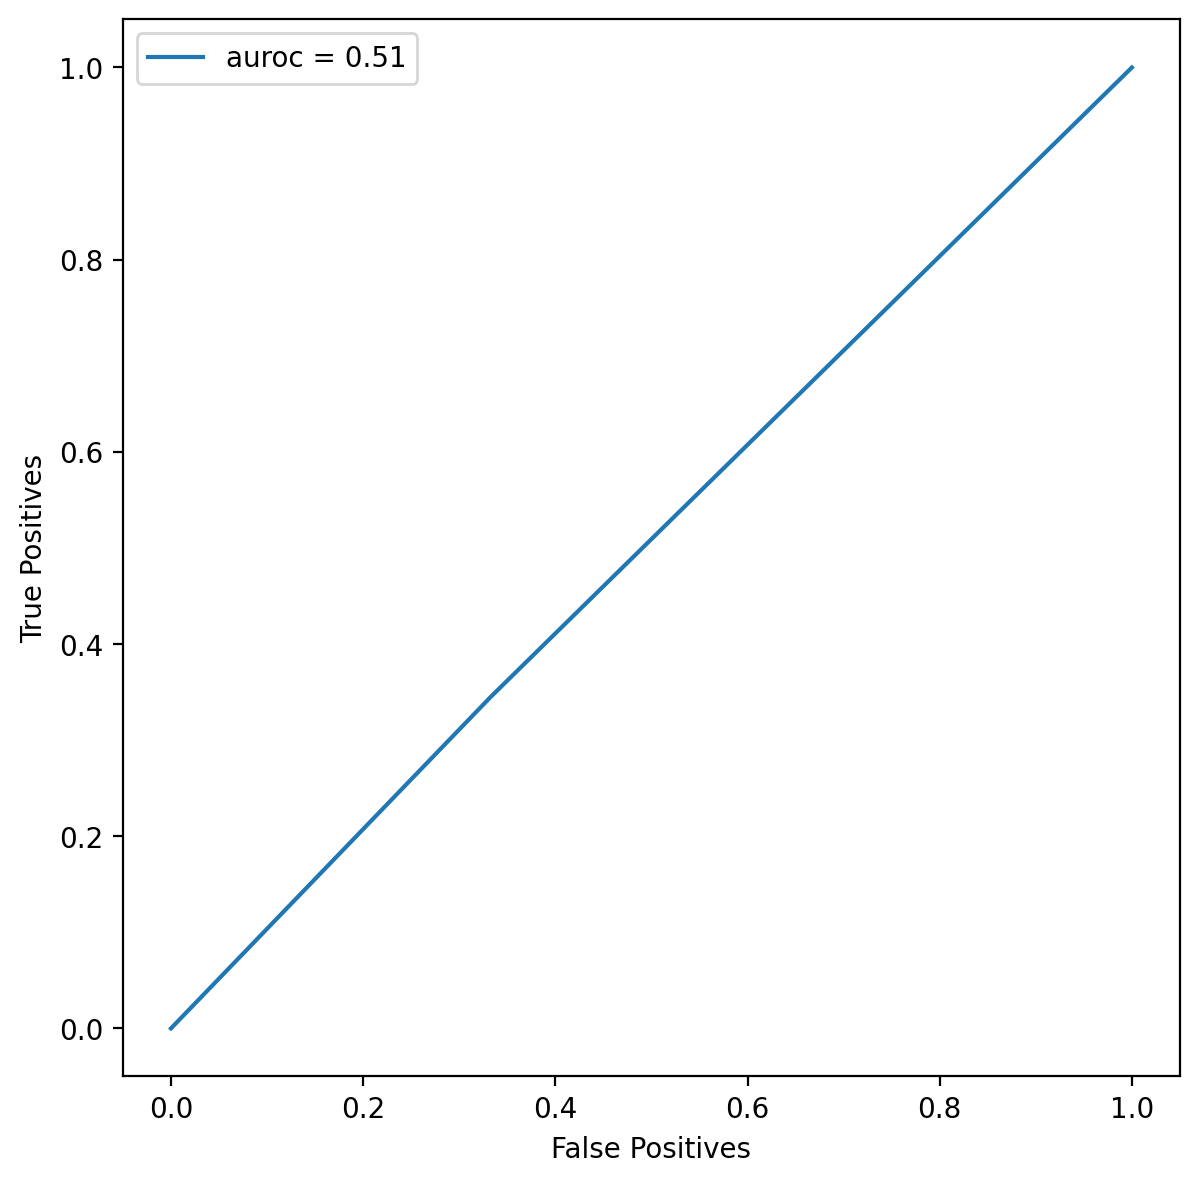

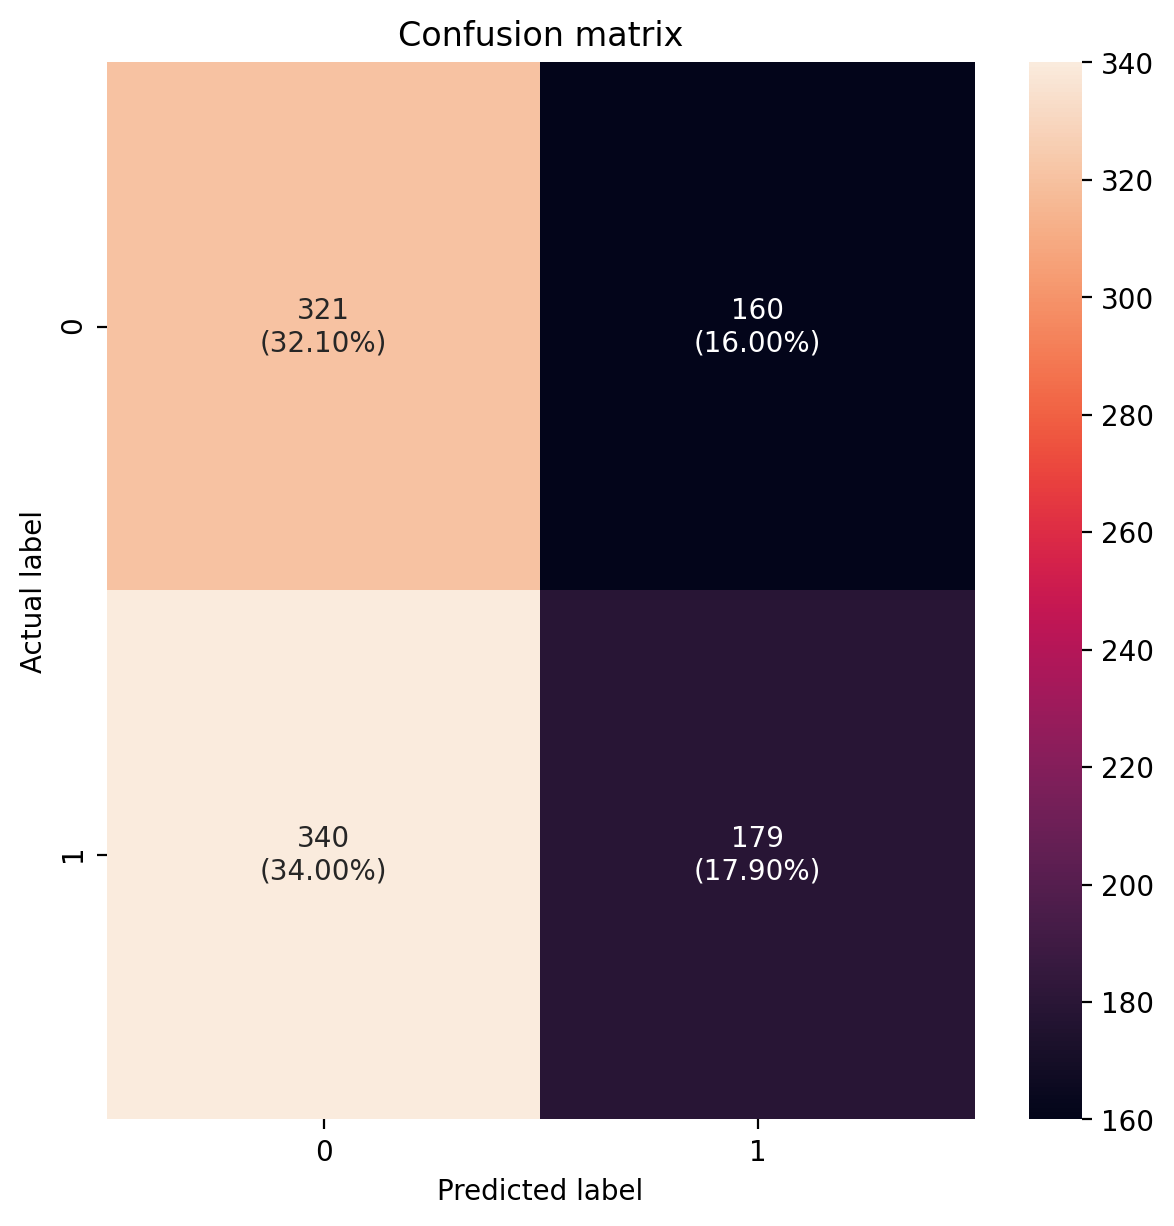

In [80]:
evaluate(encoder_fe, decoder_fe, discriminator_fe, test_dataloader, thresh_fe)

# **Fine tuning of that pre-trained AAE model**

Loading the weights for each sub-model

In [75]:
encoder_weights = '/content/drive/MyDrive/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Encoder.pth'
decoder_weights = '/content/drive/MyDrive/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Decoder.pth'
discriminator_weights = '/content/drive/MyDrive/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'

encoder_ft, decoder_ft, discriminator_ft = load_model_pretrained(encoder_weights, decoder_weights, discriminator_weights)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.flatten.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.

# **Training of the model**

The difference of previous training and this one is that we are using pre-trained weights here.

In [76]:
save_path_ft = os.path.join('/content/drive/MyDrive/GSoC/', 'weights_history_ft.pt')
encoder_ft, decoder_ft, discriminator_ft, history_ft = train_model(encoder_ft, decoder_ft, discriminator_ft, train_no_sub_dataloader, 32, save_path_ft, viz=False)

  0%|          | 0/71 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 1/32] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3601


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 2/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.2891


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 3/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3021


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 4/32] reconstruction loss: 0.0000; discriminator loss: 0.0009; generator loss: 0.3209


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 5/32] reconstruction loss: 0.0000; discriminator loss: 0.0009; generator loss: 0.3269


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 6/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3466


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 7/32] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3502


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 8/32] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3423


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 9/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3408


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 10/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3414


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 11/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3368


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 12/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3352


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 13/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3358


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 14/32] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3374


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 15/32] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3369


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 16/32] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3357


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 17/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3359


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 18/32] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3354


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 19/32] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3352


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 20/32] reconstruction loss: 0.0000; discriminator loss: 0.0002; generator loss: 0.3347


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 21/32] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3337


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 22/32] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3365


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 23/32] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3360


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 24/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3347


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 25/32] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3350


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 26/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3350


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 27/32] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3341


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 28/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3358


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 29/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3352


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 30/32] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3349


  0%|          | 0/71 [00:00<?, ?it/s]


[Epoch 31/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3338


Epoch 32/32: 100%|██████████| 71/71 [01:48<00:00,  1.53s/it]



[Epoch 32/32] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3361


# **Visualising the training metrics of this above model**

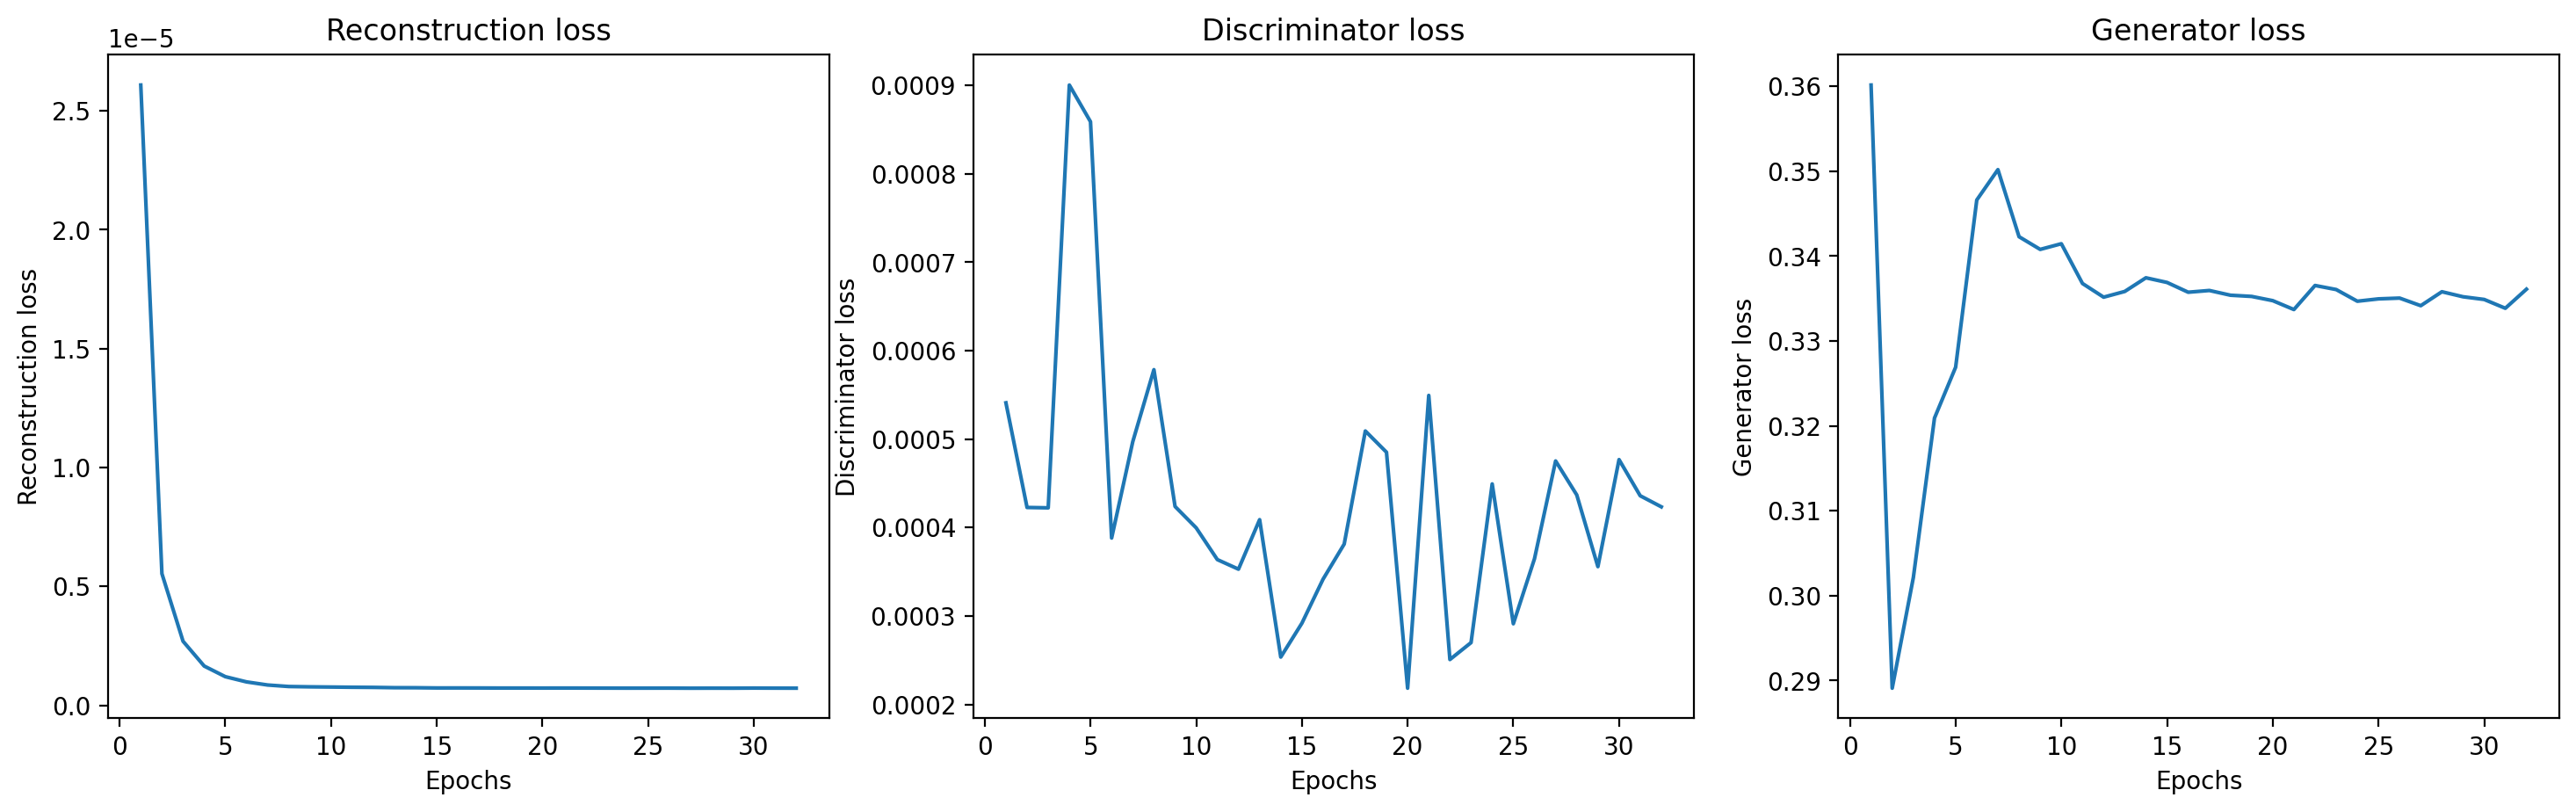

In [77]:

metrics(history_ft)

## **Evaluation of the model**

  0%|          | 0/9000 [00:00<?, ?it/s]


finding anomaly_scores statistics...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 9000/9000 [02:12<00:00, 67.85it/s]


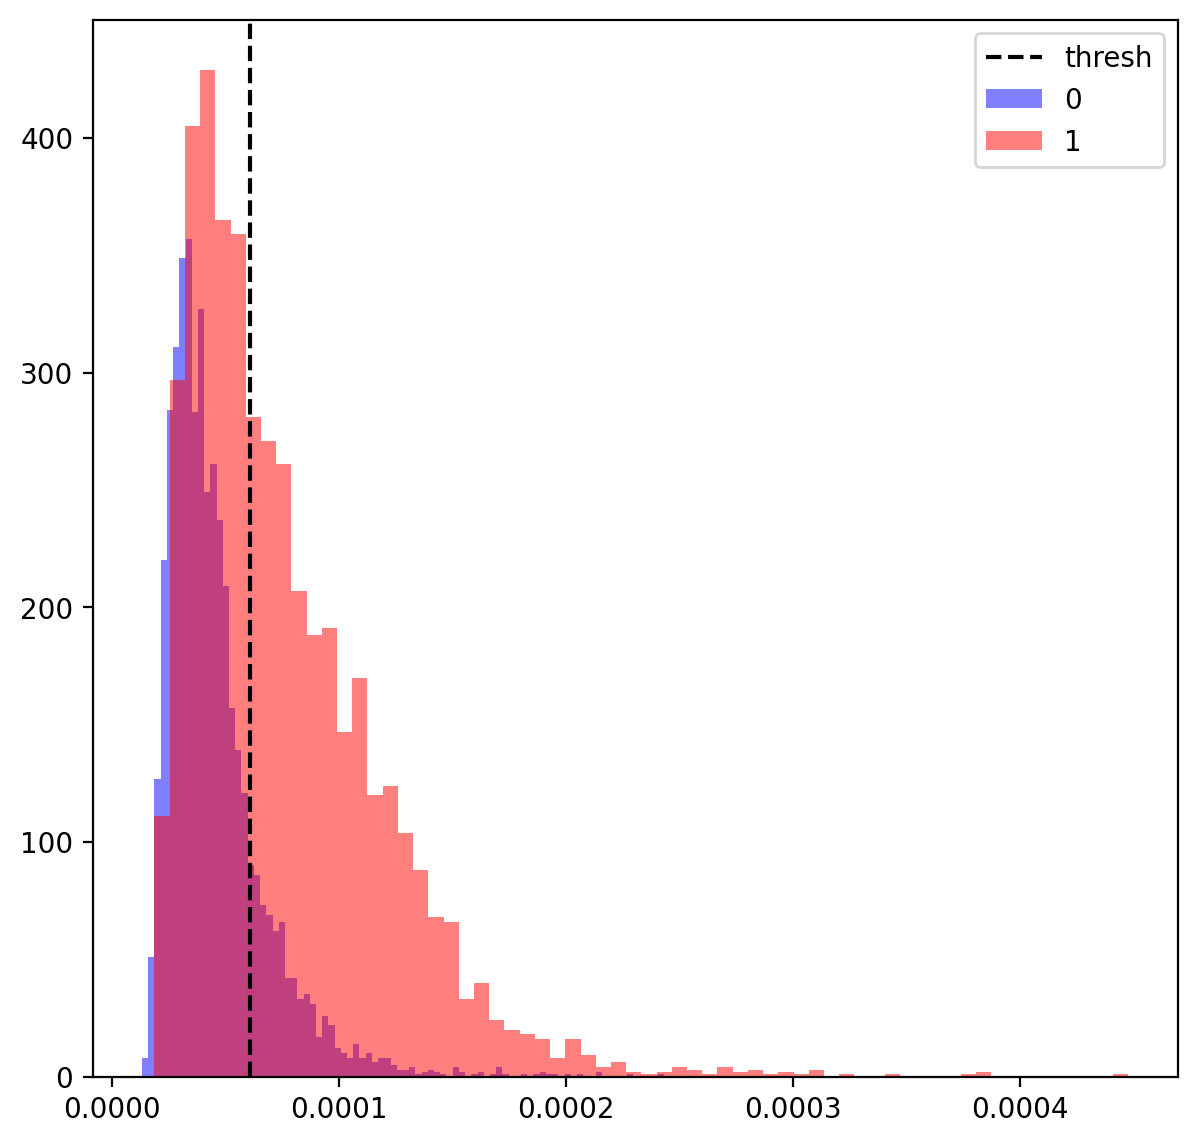

6.095093072185086e-05

In [78]:
thresh_ft = find_thresh(encoder_ft, decoder_ft, discriminator_ft, train_all_dataloader, viz=True)
thresh_ft

100%|██████████| 1000/1000 [00:13<00:00, 74.88it/s]


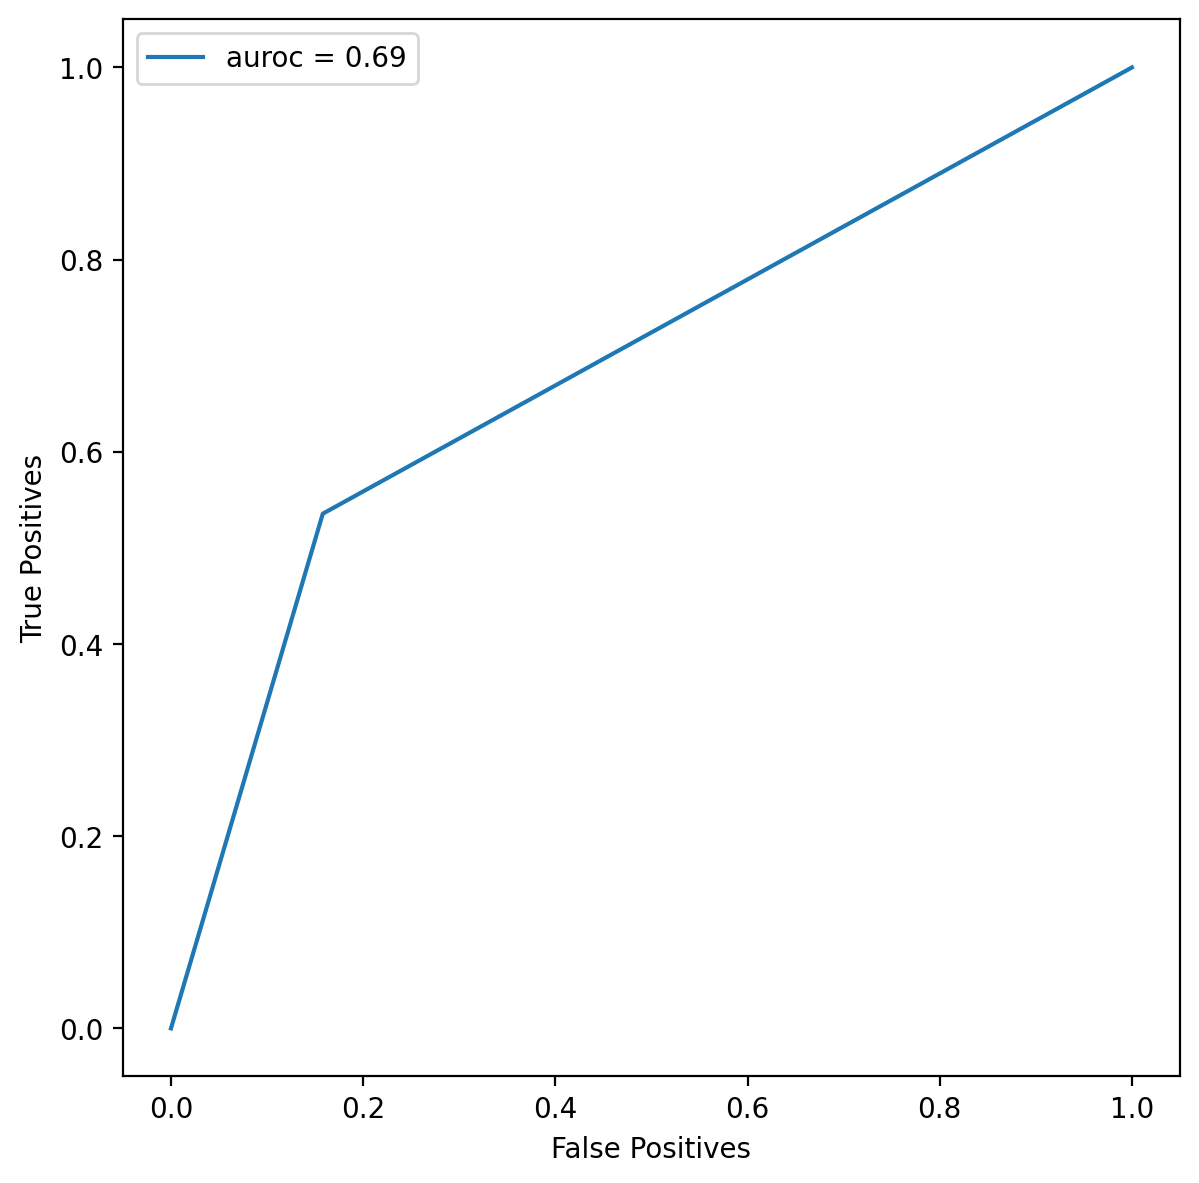

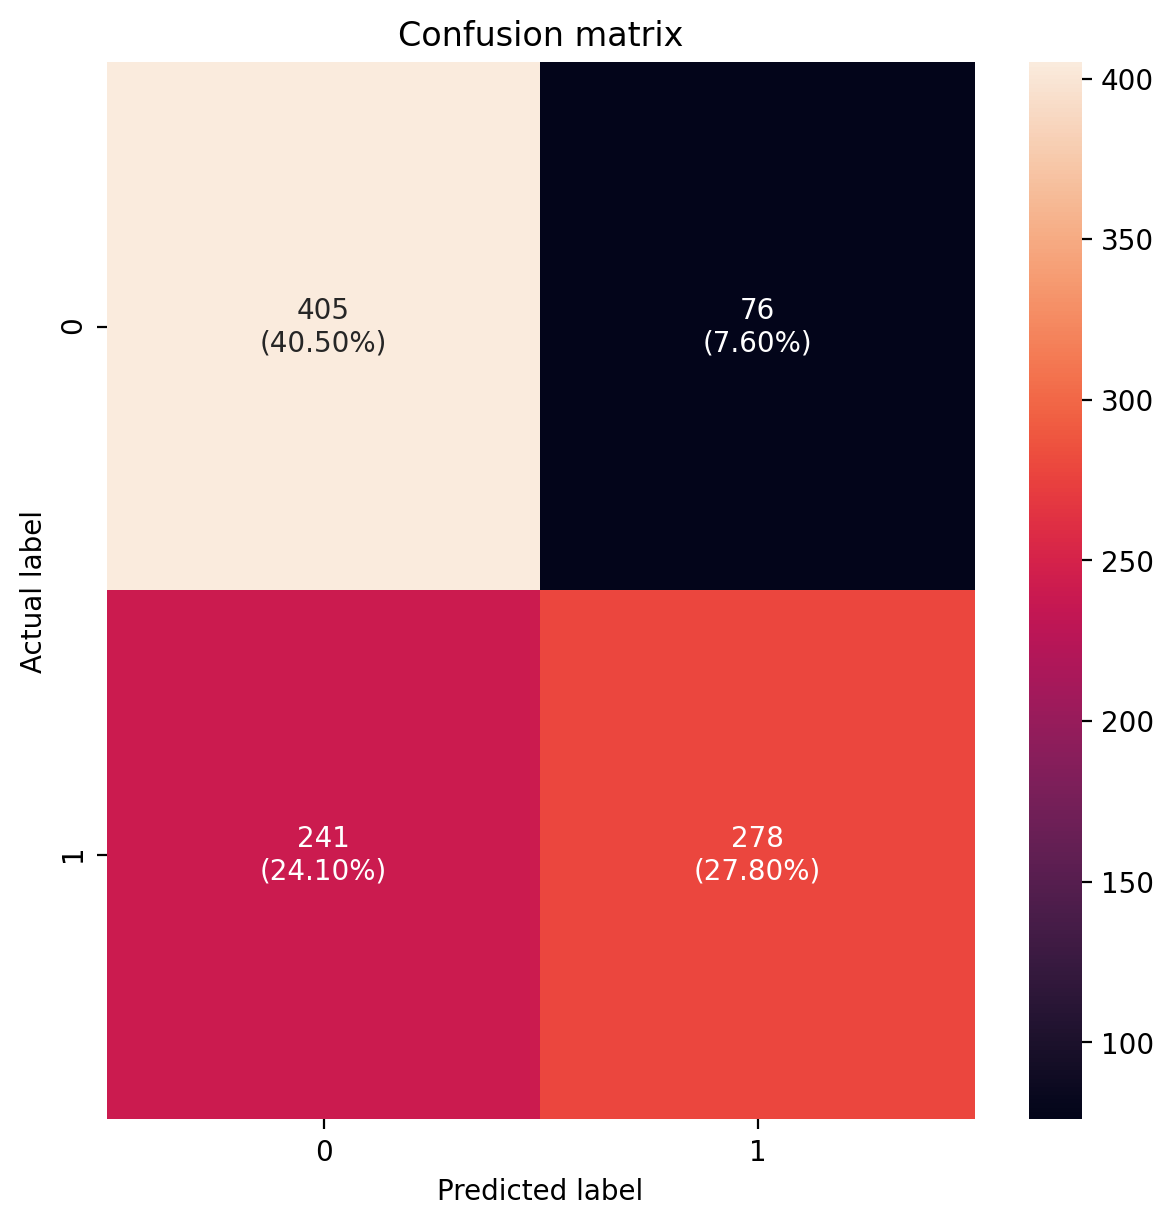

In [79]:
evaluate(encoder_ft, decoder_ft, discriminator_ft, test_dataloader, thresh_ft)

# **Abstract of the notebook**

The notebook consists of various stages:



*   On first stage we are preparing all the data to be made available on the drive including pre-trained weights and LensDataset.
*   Second stage predefines all the libraries and then Data is divided into categories. Then the exploration of data comes into play along with the data augmentation functions.
*   Then we divided data into Train and test, considering sub class as the anomaly class.
*   Defined the AAE architecture along with the functions to load the models, train the models, evluation of metrics and evaluation of threshold of the models.
*   Then we trained a model of AAE from scratch, not using the pre-trained weights given on the task. and then ran the several functions for calculating the ROC and AUROC.
*   Then we used pre-trained weights for the feature extraction and evaluated the model.
*   Then the finetuning part comes into the role, where we train the model using the given weights in the assignment and then evaluated the model.


Notes:


1.   I used 32 epoches because of the lack of GPU in my system, if we would have used more epoches we would have got more accurate model.
2.   There are still many areas to look after except epoch, for the better execution of model. Hyperparameters can be tested for better results.



